torch.Size([32, 200])


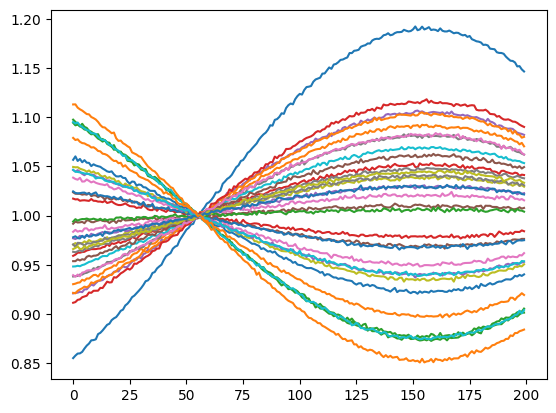

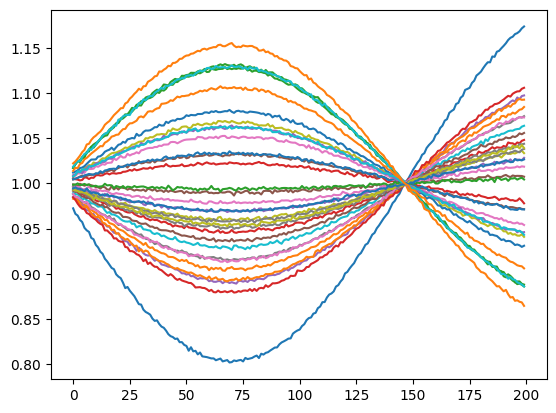

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

# Hyperparameters
N = 1    # Number of task basis functions
C = 100    # Size of learned dictionary (varied)
T = 200    # Sequence length
hidden_size = 128
batch_size = 32
train_samples = batch_size*10
test_samples = batch_size*5
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CompositionalDataset(Dataset):
    def __init__(self, num_samples, num_basis, seq_length, unseen=False, basis_seed=42, coeff_seed=None, noise = 0.001):
        """
        Args:
            num_samples (int): Number of data samples.
            num_basis (int): Number of basis functions (N).
            seq_length (int): Length of each sequence (T).
            unseen (bool): If True, generates coefficients from a different distribution for zero-shot testing.
            basis_seed (int): Seed for basis generation (ensures consistency).
            coeff_seed (int): Seed for coefficient sampling (optional).
        """
        self.num_samples = num_samples
        self.num_basis = num_basis
        self.seq_length = seq_length

        # Fix seeds for reproducibility
        np.random.seed(basis_seed)
        self.input_basis = self._generate_basis()
        self.output_basis = self._generate_basis()

        # Generate coefficients
        if coeff_seed is not None:
            np.random.seed(coeff_seed)
        self.coefficients = self._generate_coefficients(unseen)

        # Generate dataset
        self.inputs = self.coefficients @ self.input_basis + 1  # Shape: (num_samples, seq_length)
        self.inputs += noise*(np.random.randn(*self.inputs.shape)) # +  1j * 2*np.pi*np.random.rand(*self.inputs.shape)) # Add noise
        self.outputs = self.coefficients @ self.output_basis + 1  # Shape: (num_samples, seq_length)
        self.outputs += noise*(np.random.randn(*self.inputs.shape))  # Add noise

    def _generate_basis(self):
        """Generates a set of non-orthogonal basis functions and normalizes them."""
        A = np.random.randn(self.num_basis, 2)
        basis = np.sin(1*A[:, 0][:, None] * np.linspace(0, 2*np.pi, self.seq_length)[None, :] + 2*np.pi*A[:, 1][:,None] * np.ones([1, self.seq_length]))
        basis /= np.linalg.norm(basis, axis=1, keepdims=True)  # Normalize basis vectors
        return basis

    def _generate_coefficients(self, unseen):
        """Samples random coefficients for the linear combination of basis functions."""
        if unseen:
            return np.random.uniform(-2, 2, (self.num_samples, self.num_basis))  # Unseen distribution
        else:
            return np.random.randn(self.num_samples, self.num_basis)  # Training distribution

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """Retrieves a single input-output pair."""
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.outputs[idx], dtype=torch.float32)

# Example Usage
train_dataset = CompositionalDataset(num_samples=train_samples, num_basis=N, seq_length=T)
test_dataset = CompositionalDataset(num_samples=test_samples, num_basis=N, seq_length=T, unseen=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


aaa = 0
for x, y in train_loader:
    aaa+=1
    if aaa>1:
        break

    print(x.shape)
    plt.plot(x.T)
    plt.show()
    plt.plot(y.T)
    plt.show()

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
model = torch.nn.Linear(10, 2)
total_params = count_parameters(model)
trainable_params = count_trainable_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 22
Trainable parameters: 22


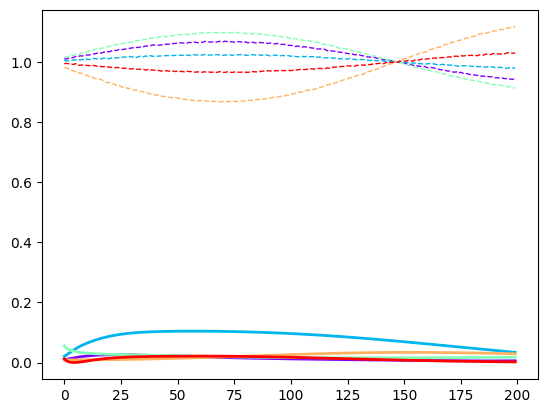

Total parameters: 460
Trainable parameters: 460


In [3]:
import matplotlib.cm as cm
torch.autograd.set_detect_anomaly(False)

# Define the oscillator system
class NonlinearOscillatorNet(nn.Module):
    def __init__(self, N, device, outputdim = 1, inputdim = 1, batchsize = 32, seed = 0):
        super().__init__()
        torch.manual_seed(seed)
        self.N = N
        self.batch_size = batchsize
        self.mu = nn.Parameter(torch.randn(N)*1)  # Learnable gains
        self.omega = nn.Parameter(torch.randn(N)*0.01)  # Learnable frequencies
        self.K = nn.Parameter(torch.randn(N, N, dtype=torch.cfloat) * 0.1)  # Parametric coupling
        self.Q = nn.Parameter(torch.randn(N, inputdim, dtype=torch.cfloat) * 0.1)  # Direct injection
        #self.P = nn.Parameter(torch.randn(N, N, N, dtype=torch.cfloat) * 0.001)  # Parametric up-conversion
        self.D = nn.Parameter(torch.randn(outputdim, N, dtype=torch.cfloat) * 0.1)  # Decoder weights
        self.r = nn.Parameter(torch.randn(self.batch_size, N, dtype=torch.cfloat, device=device)*0.1)

        self.z = torch.randn(self.batch_size, N, dtype=torch.cfloat, device=device)  # Ensure batch dim

        self.dt = 0.1

    # Inside the forward method:
    def forward(self, I_t):
        z = self.z.detach()
        z_t = []
        for t in range(200):
            dz_dt = (self.mu + 1j * self.omega + torch.einsum('ij,bj->bi', self.K, z) - torch.abs(z - self.r)**2) * (z-self.r)  # Self-dynamics
            dz_dt += torch.einsum('ik,bk->bi', self.Q, I_t[:, :, t])  # Direct injection from input
            # dz_dt += torch.einsum('ijk,bj,bk->bi', self.P, self.z, self.z)  # Parametric up-conversion

            z = z + self.dt * dz_dt  # Euler integration step
            z_t.append(z.clone())

        z_t = torch.stack(z_t, dim=1)  # Shape: (batch, T, N)
        o_t = torch.abs(torch.einsum('btj,jk->bkt', z_t, self.D.T))**2  # Intensity decoder: (batch, T)
        self.z = z.detach()
        return o_t, z_t

# Instantiate model and optimizer
aaa = 0
for x, y in train_loader:
    aaa+=1
    if aaa>1:
        break
model = NonlinearOscillatorNet(10, x.device, outputdim = 1, inputdim = 1, batchsize = x.shape[0])
output, hidden = model(x.unsqueeze(1))

Nclrs = 5
cmap = cm.rainbow(np.linspace(0, 1, Nclrs))
for iii in range(Nclrs):
  plt.plot(y[iii], '--', lw = 1, color = cmap[iii,:])
  plt.plot(output[iii,0].detach().numpy(), lw = 2, color = cmap[iii,:])
plt.show()
total_params = count_parameters(model)
trainable_params = count_trainable_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

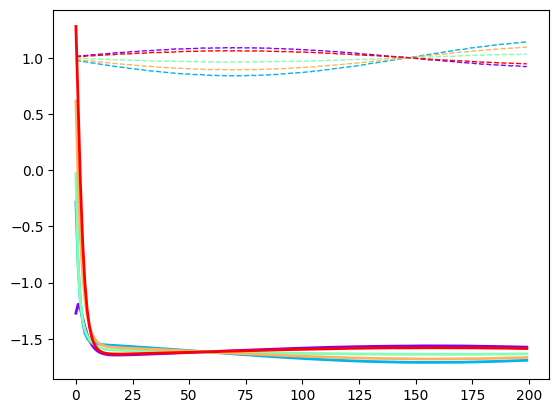

Total parameters: 720
Trainable parameters: 400


In [4]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, N, device, outputdim=1, inputdim=1, batchsize=32, seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.N = N
        self.batch_size = batchsize
        self.device = device
        self.dt = 0.1

        # Define GRU-based recurrent network
        self.rnn = nn.GRU(input_size=inputdim, hidden_size=N, num_layers=1, batch_first=True, dtype=torch.float)
        self.D = nn.Parameter(torch.randn(outputdim, N, dtype=torch.float) * 1)  # Decoder weights

        # Initialize hidden state
        self.h = nn.Parameter(torch.randn(batchsize, N, dtype=torch.float, device=device) * 1, requires_grad=False)

    def forward(self, I_t):
        batch_size, input_dim, T = I_t.shape

        # Reshape input for GRU (batch_size, T, inputdim)
        I_t_reshaped = I_t.permute(0, 2, 1)  # Move time to second dimension

        # Forward through RNN
        z_t, _ = self.rnn(I_t_reshaped, self.h.unsqueeze(0))  # (batch_size, T, N)
        self.h = nn.Parameter(z_t[:, -1, :].detach(), requires_grad=False)  # Detach last hidden state

        # Intensity decoding (batch, T, outputdim)
        o_t = torch.einsum('btj,jk->bkt', z_t, self.D.T)
        return o_t, z_t

# Instantiate model and optimizer
aaa = 0
for x, y in train_loader:
    aaa+=1
    if aaa>1:
        break
modelR = RNNModel(10, x.device, outputdim = 1, inputdim = 1, batchsize = x.shape[0])
output, hidden = modelR(x.unsqueeze(1))

Nclrs = 5
cmap = cm.rainbow(np.linspace(0, 1, Nclrs))
for iii in range(Nclrs):
  plt.plot(y[iii], '--', lw = 1, color = cmap[iii,:])
  plt.plot(output[iii,0].detach().numpy(), lw = 2, color = cmap[iii,:])
plt.show()

total_params = count_parameters(modelR)
trainable_params = count_trainable_parameters(modelR)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


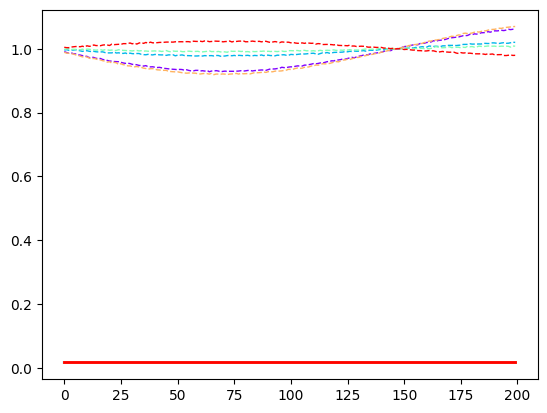

Total parameters: 20618
Trainable parameters: 20554


In [5]:
class TransformerModel(nn.Module):
    def __init__(self, N, device, outputdim=1, inputdim=1, batchsize=32, seed=0, num_heads=1, num_layers=2):
        super().__init__()
        torch.manual_seed(seed)
        self.N = N
        self.batch_size = batchsize
        self.device = device

        self.embed = nn.Linear(inputdim, N, dtype=torch.float)  # Input projection
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=N, nhead=num_heads, dtype=torch.float), num_layers=num_layers
        )
        self.D = nn.Parameter(torch.randn(outputdim, N, dtype=torch.float) * 0.1)  # Decoder weights

        # Initialize learnable memory representation
        self.z = nn.Parameter(torch.randn(batchsize, N, dtype=torch.cfloat, device=device) * 1, requires_grad=False)

        self.dt = 0.1

    def forward(self, I_t):
        batch_size, input_dim, T = I_t.shape

        # Reshape and project input (batch, T, N)
        I_t_proj = self.embed(I_t.permute(0, 2, 1))

        # Apply Transformer encoder
        z_t = self.transformer(I_t_proj.permute(1, 0, 2))  # Transformer expects (T, batch, N)
        z_t = z_t.permute(1, 0, 2)  # Back to (batch, T, N)

        self.z = nn.Parameter(z_t[:, -1, :].detach(), requires_grad=False)  # Detach last hidden state

        # Intensity decoding
        o_t = torch.einsum('btj,jk->bkt', z_t, self.D.T)
        return o_t, z_t

  # Instantiate model and optimizer
aaa = 0
for x, y in train_loader:
    aaa+=1
    if aaa>1:
        break
modelT = TransformerModel(2, x.device, outputdim = 1, inputdim = 1, batchsize = x.shape[0])
output, hidden = modelT(x.unsqueeze(1))

Nclrs = 5
cmap = cm.rainbow(np.linspace(0, 1, Nclrs))
for iii in range(Nclrs):
  plt.plot(y[iii], '--', lw = 1, color = cmap[iii,:])
  plt.plot(output[iii,0].detach().numpy(), lw = 2, color = cmap[iii,:])
plt.show()

total_params = count_parameters(modelT)
trainable_params = count_trainable_parameters(modelT)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


In [6]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=500, lr=1e-4, name='none'):
    """
    Trains a PyTorch model and tracks train and validation losses.

    Args:
        model: PyTorch model (RNN or Transformer).
        train_loader: DataLoader for training set.
        val_loader: DataLoader for validation set.
        epochs: Number of epochs.
        lr: Learning rate.

    Returns:
        train_losses, val_losses: Lists of loss values for each epoch.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            #print(y.shape, x.shape)
            optimizer.zero_grad()
            y_pred, z_t = model(x.unsqueeze(1))

            #print(y_pred.shape, y.shape, x.shape)
            #print(y_pred)
            loss = criterion(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_pred, z_t = model(x.unsqueeze(1))
                val_loss += criterion(y_pred, y.unsqueeze(1)).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if epoch % 50 == 0:
          print("Epoch {epoch}: Loss = {train_loss:.5f}, ValLoss = {val_loss:.5f}")
          output = y_pred

          # Plot target vs. network output for one example
          Nclrs = np.min([5, model.N])
          fig = plt.figure(figsize=(20, 4))
          fig.add_subplot(1, 3, 1)
          cmap = cm.rainbow(np.linspace(0, 1, Nclrs))
          for iii in range(Nclrs):
            plt.plot(y[iii], '--', lw = 1, color = cmap[iii,:])
            plt.plot(output[iii,0].detach().numpy(), lw = 2, color = cmap[iii,:])
          plt.xlabel("Time Steps")
          plt.ylabel("Output Intensity")
          plt.title(f"Training Progress at Epoch {epoch}")
          plt.legend()

          # Plot individual mode amplitudes
          fig.add_subplot(1, 3, 2)
          for k in range(Nclrs):
              plt.plot(torch.abs(z_t[0, :, k]).detach().numpy(), label=f"Mode {k}")
          plt.xlabel("Time Steps")
          plt.ylabel("Amplitude |z_k|")
          plt.title(f"Mode Dynamics at Epoch {epoch}")
          #plt.legend()

          # Compute and plot spectral content of oscillations
          fft_spectrum = torch.fft.fft(z_t[0], dim=0)
          freqs = torch.fft.fftfreq(T, d=model.dt)

          fig.add_subplot(1, 3, 3)
          for k in range(Nclrs):
              plt.plot(freqs[:T//2], torch.abs(fft_spectrum[:T//2, k]).detach().numpy(), label=f"Mode {k}")
          plt.xlabel("Frequency")
          plt.ylabel("Magnitude")
          plt.title(f"Spectral Content of Oscillations at Epoch {epoch}")
          plt.xscale('log')
          plt.yscale('log')
          #plt.legend()
          plt.show()

        #print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses, model



In [ ]:
osc_train_loss, osc_val_loss, model = train_model(model, train_loader, test_loader, epochs=1000, name='osc')

In [ ]:
def plot_loss_curves(train_loss, val_loss, model_name):
    """Plots train vs. validation loss over epochs."""
    plt.plot(train_loss, label="Train Loss", lw = 3, color='k')
    plt.plot(val_loss, label="Validation Loss", lw = 3, color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Train vs. Validation Loss: {model_name}")
    plt.legend()
    plt.yscale('log')
    plt.show()

plot_loss_curves(rnn_train_loss, rnn_val_loss, "RNN")
plot_loss_curves(osc_train_loss, osc_val_loss, "Hopf")
plot_loss_curves(trs_train_loss, trs_val_loss, "Trans")